# Multi-Scale JEPA Training and Embedding Comparison

Train JEPA at second (1s), minute (60s), and 20ms scales. Volume and count features
are normalized by bar_sec so they are comparable across scales. Compare embeddings.

In [50]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
try:
    from torch.amp import GradScaler, autocast
    _autocast = lambda dt, en, dtype: autocast(dt, enabled=en, dtype=dtype)
    _scaler = lambda dt, en: GradScaler(dt, enabled=en)
except ImportError:
    from torch.cuda.amp import GradScaler, autocast
    _autocast = lambda dt, en, dtype: autocast(enabled=en)
    _scaler = lambda dt, en: GradScaler(enabled=en)
from torch.optim import AdamW

ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else (Path.cwd() if (Path.cwd() / "pyproject.toml").exists() else Path.cwd().parent)
MODELS = ROOT / "models"
if str(MODELS) not in sys.path:
    sys.path.insert(0, str(MODELS))
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
os.chdir(ROOT)

from eb_jepa.datasets.utils import init_data
from eb_jepa.architectures import InverseDynamicsModel, RNNPredictor, TimeSeriesEncoder
from eb_jepa.jepa import JEPA, JEPAProbe
from eb_jepa.losses import CosineLossSeq, VC_IDM_Sim_Regularizer
from eb_jepa.state_decoder import MLPStateHead

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_dir = ROOT / "notebooks" / "outputs"
out_dir.mkdir(exist_ok=True)

In [51]:
SCALES = [
    {"bar_sec": 0.02, "label": "20ms"},
    {"bar_sec": 1, "label": "1s"},
    {"bar_sec": 60, "label": "60s"},
]
NUM_EPOCHS = 2
NUM_STEPS_PER_SCALE = 2000

In [52]:
def build_jepa(state_dim, seq_len, device):
    encoder = TimeSeriesEncoder(input_dim=state_dim, hidden_dim=64, output_dim=2, use_final_ln=False)
    # final_ln=Identity: LayerNorm on predictor forces zero-mean -> y=-x for 2D; remove it
    predictor = RNNPredictor(
        hidden_size=encoder.mlp_output_dim,
        action_dim=1,
        final_ln=nn.Identity(),
    )
    _, f, _, h, w = encoder(torch.rand(1, state_dim, seq_len, 1, 1)).shape
    idm = InverseDynamicsModel(state_dim=h * w * f, hidden_dim=256, action_dim=1).to(device)
    # cov/std DECORRELATE; sim_coeff_t forces smooth trajectories -> cone; lower = more spread
    regularizer = VC_IDM_Sim_Regularizer(
        cov_coeff=8, std_coeff=8, sim_coeff_t=1, idm_coeff=0.5,
        idm=idm, first_t_only=False, projector=None,
        spatial_as_samples=False, idm_after_proj=False, sim_t_after_proj=False,
    )
    predcost = CosineLossSeq()
    # pred_coeff lower so decorrelation (cov, corr_penalty) can compete; 25 dominated and kept y=-x
    jepa = JEPA(encoder, nn.Identity(), predictor, regularizer, predcost, pred_coeff=8.0).to(device)
    return jepa

def train_scale(loader, data_config, scale_label, num_steps):
    ds = loader.dataset.dataset if hasattr(loader.dataset, "dataset") else loader.dataset
    state_dim = getattr(data_config, "state_dim", ds.state_dim)
    seq_len = getattr(data_config, "seq_len", ds.seq_len)
    jepa = build_jepa(state_dim, seq_len, device)
    state_head = MLPStateHead(
        input_dim=jepa.encoder.mlp_output_dim,
        output_dim=state_dim,
        normalizer=getattr(ds, "normalizer", None),
    ).to(device)
    state_prober = JEPAProbe(jepa=jepa, head=state_head, hcost=nn.MSELoss())
    jepa_opt = AdamW(jepa.parameters(), lr=1e-3, weight_decay=1e-6)
    probe_opt = AdamW(state_head.parameters(), lr=1e-3, weight_decay=1e-5)
    scaler = _scaler(device.type, False)
    dtype = torch.float32
    losses = []
    pred_losses = []
    reg_losses = []
    step = 0
    loader_iter = iter(loader)
    while step < num_steps:
        try:
            x_b, a_b, loc_b, _, _ = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            x_b, a_b, loc_b, _, _ = next(loader_iter)
        x_b = x_b.permute(0, 2, 1, 3, 4).to(device)
        a_b = a_b.permute(0, 2, 1).to(device)
        loc_b = loc_b.permute(0, 2, 1).to(device)
        x_b = torch.nan_to_num(x_b, nan=0.0, posinf=0.0, neginf=0.0)
        a_b = torch.nan_to_num(a_b, nan=0.0, posinf=0.0, neginf=0.0)
        loc_b = torch.nan_to_num(loc_b, nan=0.0, posinf=0.0, neginf=0.0)
        jepa_opt.zero_grad()
        with _autocast(device.type, False, dtype):
            _, (jepa_loss, rloss, _, _, pl) = jepa.unroll(
                x_b, a_b, nsteps=8, unroll_mode="autoregressive", ctxt_window_time=1,
                compute_loss=True, return_all_steps=False,
            )
        pred_losses.append(pl.item())
        reg_losses.append(rloss.item())
        scaler.scale(jepa_loss).backward()
        torch.nn.utils.clip_grad_norm_(jepa.parameters(), max_norm=1.0)
        scaler.step(jepa_opt)
        scaler.update()
        probe_opt.zero_grad()
        with _autocast(device.type, False, dtype):
            probe_loss = state_prober(observations=x_b[:, :, :1], targets=loc_b[:, :, :1])
        scaler.scale(probe_loss).backward()
        torch.nn.utils.clip_grad_norm_(state_head.parameters(), max_norm=1.0)
        scaler.step(probe_opt)
        scaler.update()
        total = jepa_loss.item() + probe_loss.item()
        losses.append(total)
        step += 1
        if step % 100 == 0:
            print(f"  {scale_label} step {step}/{num_steps} total={total:.4f} pred={pl.item():.4f} reg={rloss.item():.4f}")
    jepa.eval()
    all_z = []
    with torch.no_grad():
        for i, (x_b, _, _, _, _) in enumerate(loader):
            if i >= 16:
                break
            x_b = x_b.permute(0, 2, 1, 3, 4).to(device)
            x_b = torch.nan_to_num(x_b, nan=0.0, posinf=0.0, neginf=0.0)
            z_b = jepa.encode(x_b)
            all_z.append(z_b.cpu())
    z_all = torch.cat(all_z, dim=0)
    z_2d = z_all[:, :, :, 0, 0].permute(0, 2, 1)
    return jepa, np.array(losses), np.array(pred_losses), np.array(reg_losses), z_2d

In [53]:
results = {}
for scale in SCALES:
    print(f"\n--- Scale: {scale['label']} (bar_sec={scale['bar_sec']}) ---")
    loader, val_loader, data_config = init_data("hft_timeseries", cfg_data={"bar_sec": scale["bar_sec"]})
    print(f"  Batches: {len(loader)}, batch_size: {data_config.batch_size}")
    jepa, losses, pred_losses, reg_losses, z_2d = train_scale(loader, data_config, scale["label"], NUM_STEPS_PER_SCALE)
    results[scale["label"]] = {"losses": losses, "pred_losses": pred_losses, "reg_losses": reg_losses, "z_2d": z_2d, "jepa": jepa}


--- Scale: 20ms (bar_sec=0.02) ---
  Batches: 140, batch_size: 64
  20ms step 100/2000 total=4.4187 pred=0.0009 reg=4.3816
  20ms step 200/2000 total=3.8058 pred=0.0017 reg=3.7571
  20ms step 300/2000 total=3.7666 pred=0.0016 reg=3.7352
  20ms step 400/2000 total=2.2308 pred=0.0418 reg=1.8743
  20ms step 500/2000 total=0.6676 pred=0.0404 reg=0.3152
  20ms step 600/2000 total=0.8210 pred=0.0321 reg=0.5412
  20ms step 700/2000 total=1.1619 pred=0.0149 reg=1.0157
  20ms step 800/2000 total=1.4706 pred=0.0151 reg=1.3270
  20ms step 900/2000 total=0.7840 pred=0.0121 reg=0.6650
  20ms step 1000/2000 total=0.4393 pred=0.0138 reg=0.3108
  20ms step 1100/2000 total=1.1196 pred=0.0167 reg=0.9658
  20ms step 1200/2000 total=0.7160 pred=0.0137 reg=0.5881
  20ms step 1300/2000 total=0.8225 pred=0.0082 reg=0.7408
  20ms step 1400/2000 total=0.7188 pred=0.0073 reg=0.6439
  20ms step 1500/2000 total=0.5859 pred=0.0074 reg=0.5119
  20ms step 1600/2000 total=0.4592 pred=0.0079 reg=0.3731
  20ms step 17

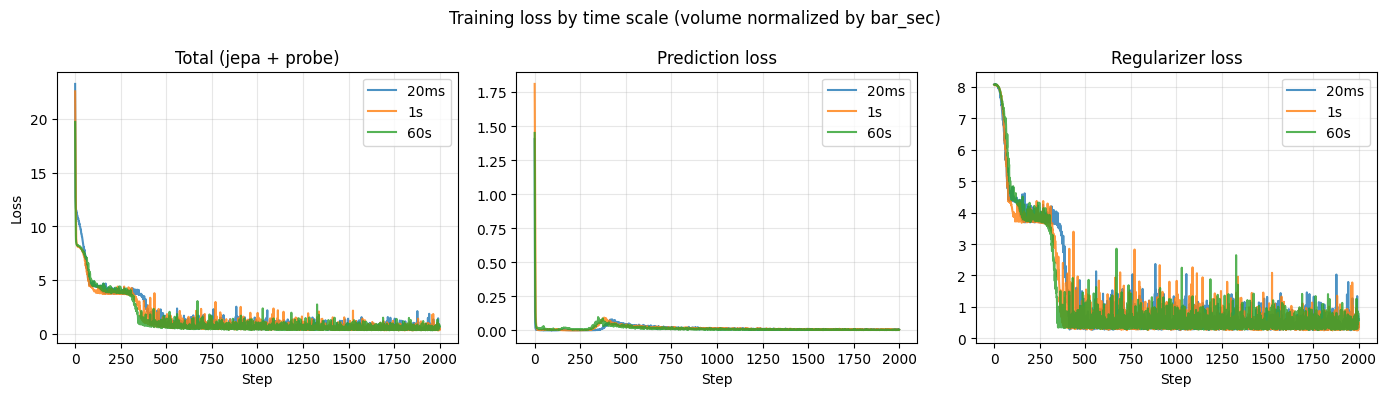

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
for label, r in results.items():
    axes[0].plot(r["losses"], label=label, alpha=0.8)
    axes[1].plot(r["pred_losses"], label=label, alpha=0.8)
    axes[2].plot(r["reg_losses"], label=label, alpha=0.8)
axes[0].set_ylabel("Loss")
axes[0].set_title("Total (jepa + probe)")
axes[1].set_title("Prediction loss")
axes[2].set_title("Regularizer loss")
for ax in axes:
    ax.set_xlabel("Step")
    ax.legend()
    ax.grid(True, alpha=0.3)
plt.suptitle("Training loss by time scale (volume normalized by bar_sec)")
plt.tight_layout()
plt.savefig(out_dir / "multiscale_losses.png", dpi=100)
plt.show()

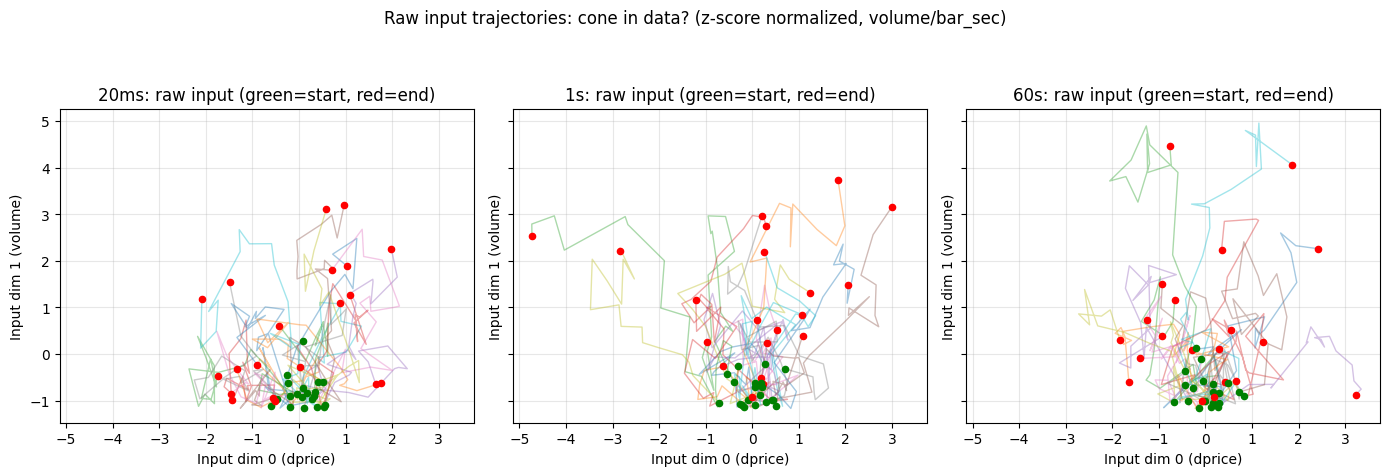

In [55]:
# raw input trajectories: cone in data or model? plot first 2 dims (dprice, volume) of normalized input
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True, sharey=True)
for idx, scale in enumerate(SCALES):
    loader, _, _ = init_data("hft_timeseries", cfg_data={"bar_sec": scale["bar_sec"]})
    x_b, _, _, _, _ = next(iter(loader))
    x_b = x_b.permute(0, 2, 1, 3, 4)
    x_2d = x_b[:, :2, :, 0, 0].permute(0, 2, 1).numpy()
    ax = axes[idx]
    n_show = min(20, x_2d.shape[0])
    for i in range(n_show):
        ax.plot(x_2d[i, :, 0], x_2d[i, :, 1], alpha=0.4, linewidth=1)
        ax.scatter(x_2d[i, 0, 0], x_2d[i, 0, 1], s=20, c="green", zorder=5)
        ax.scatter(x_2d[i, -1, 0], x_2d[i, -1, 1], s=20, c="red", zorder=5)
    ax.set_xlabel("Input dim 0 (dprice)")
    ax.set_ylabel("Input dim 1 (volume)")
    ax.set_title(f"{scale['label']}: raw input (green=start, red=end)")
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)
plt.suptitle("Raw input trajectories: cone in data? (z-score normalized, volume/bar_sec)")
plt.tight_layout()
plt.savefig(out_dir / "multiscale_raw_input_trajectories.png", dpi=120)
plt.show()

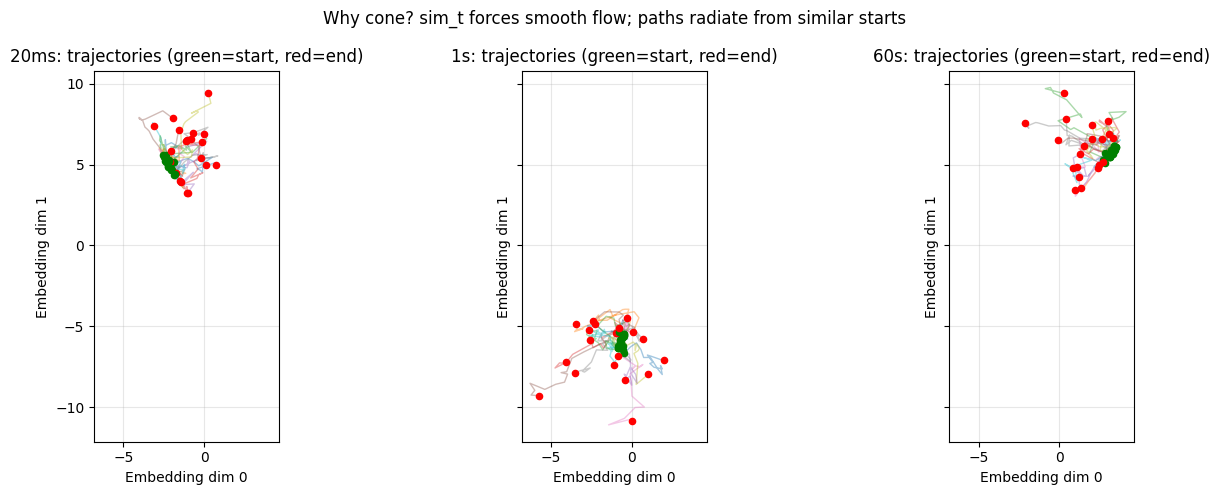

In [56]:
# trajectory plot: why cone? sim_t forces smooth flow; paths radiate from start -> cone
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True, sharey=True)
for idx, (label, r) in enumerate(results.items()):
    ax = axes[idx]
    z = r["z_2d"].numpy()
    n_show = min(20, z.shape[0])
    for i in range(n_show):
        ax.plot(z[i, :, 0], z[i, :, 1], alpha=0.4, linewidth=1)
        ax.scatter(z[i, 0, 0], z[i, 0, 1], s=20, c="green", zorder=5)
        ax.scatter(z[i, -1, 0], z[i, -1, 1], s=20, c="red", zorder=5)
    ax.set_xlabel("Embedding dim 0")
    ax.set_ylabel("Embedding dim 1")
    ax.set_title(f"{label}: trajectories (green=start, red=end)")
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)
plt.suptitle("Why cone? sim_t forces smooth flow; paths radiate from similar starts")
plt.tight_layout()
plt.savefig(out_dir / "multiscale_trajectories.png", dpi=120)
plt.show()

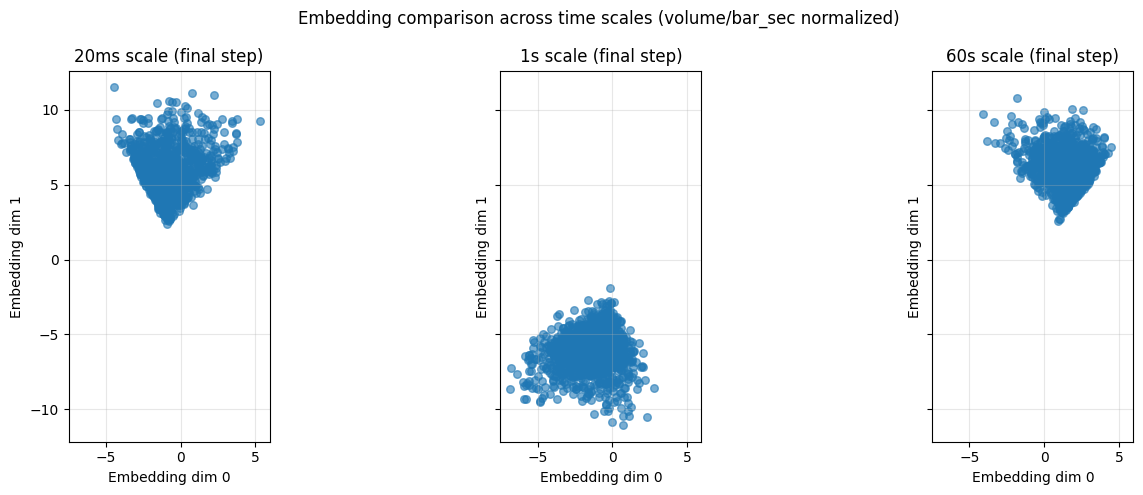

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True, sharey=True)
for idx, (label, r) in enumerate(results.items()):
    ax = axes[idx]
    z = r["z_2d"]
    z_end = z[:, -1, :].numpy()
    ax.scatter(z_end[:, 0], z_end[:, 1], alpha=0.6, s=30, label=label)
    ax.set_xlabel("Embedding dim 0")
    ax.set_ylabel("Embedding dim 1")
    ax.set_title(f"{label} scale (final step)")
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)
plt.suptitle("Embedding comparison across time scales (volume/bar_sec normalized)")
plt.tight_layout()
plt.savefig(out_dir / "multiscale_embeddings.png", dpi=120)
plt.show()

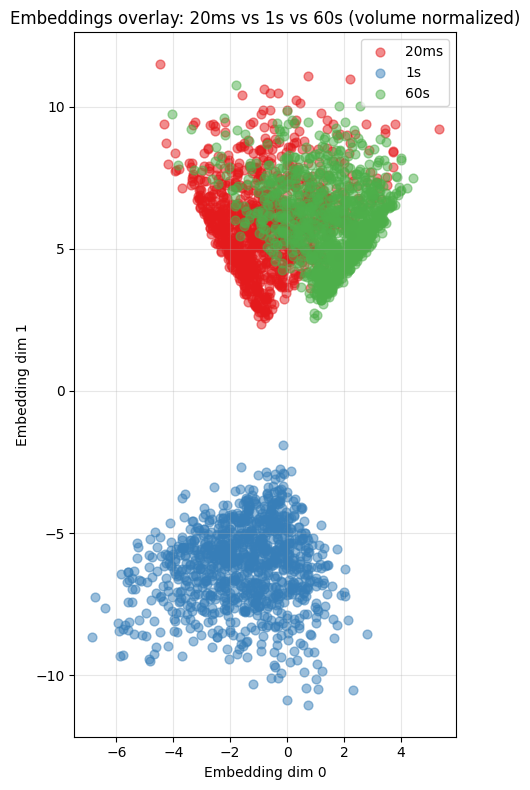

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
colors = ["#e41a1c", "#377eb8", "#4daf4a"]
for idx, (label, r) in enumerate(results.items()):
    z = r["z_2d"]
    z_end = z[:, -1, :].numpy()
    ax.scatter(z_end[:, 0], z_end[:, 1], alpha=0.5, s=40, c=colors[idx], label=label)
ax.set_xlabel("Embedding dim 0")
ax.set_ylabel("Embedding dim 1")
ax.set_title("Embeddings overlay: 20ms vs 1s vs 60s (volume normalized)")
ax.legend()
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out_dir / "multiscale_embeddings_overlay.png", dpi=120)
plt.show()

In [59]:
print("\n--- Summary ---")
for label, r in results.items():
    z = r["z_2d"][:, -1, :].numpy()
    corr = np.corrcoef(z[:, 0], z[:, 1])[0, 1]
    cov = np.cov(z.T)
    eigvals = np.sort(np.linalg.eigvalsh(cov))[::-1]
    ratio = eigvals[1] / (eigvals[0] + 1e-10)
    print(f"{label}: mean=({z[:, 0].mean():.3f}, {z[:, 1].mean():.3f}), std=({z[:, 0].std():.3f}, {z[:, 1].std():.3f})")
    print(f"  corr(dim0,dim1)={corr:.4f}, eig_ratio={ratio:.4f} (low ratio = collapse)")


--- Summary ---
20ms: mean=(-0.828, 5.930), std=(1.392, 1.585)
  corr(dim0,dim1)=0.0995, eig_ratio=0.7205 (low ratio = collapse)
1s: mean=(-1.502, -6.145), std=(1.611, 1.446)
  corr(dim0,dim1)=0.0862, eig_ratio=0.7582 (low ratio = collapse)
60s: mean=(1.406, 5.962), std=(1.312, 1.391)
  corr(dim0,dim1)=-0.1450, eig_ratio=0.7303 (low ratio = collapse)


In [60]:
# cone interpretation: compare raw_input_trajectories.png vs multiscale_trajectories.png
# 1. cone in raw data -> reflects market structure (meaningful)
# 2. cone only in embeddings -> model artifact (try sim_coeff_t=0)
# 3. normalization can create cone in input (early t similar, later t diverge)
print("Compare raw_input_trajectories.png vs multiscale_trajectories.png to see if cone is data or model.")

Compare raw_input_trajectories.png vs multiscale_trajectories.png to see if cone is data or model.
